In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyslim, tskit
import itertools
import scipy.special
import os, subprocess, sys
from Bio import Phylo
from io import StringIO
import msprime
import tqdm
from pathlib import Path
import statsmodels.stats.proportion
import glob
import joblib
import seaborn as sns
import os

sys.path.append(str(Path(os.getcwd()).parent))

In [4]:
from src import extract_tree_stats, curve_inference, estimators, loader

In [5]:
os.environ['R_HOME'] = "/home/rs2145/rs2145/software/anaconda3/envs/dated_selection/lib/R"

In [6]:
%load_ext rpy2.ipython

# Neutral tree plots

In [347]:
#filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=*/output.trees")
filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/neutral_desai_bigger_20231227/seed=*/output.trees")

trees_filename = filenames[0]

In [348]:
n_samples_per_time = 100

ts = loader.load_tree_sequence_from_slim(
    filename = trees_filename,
    n_samples_per_time = [n_samples_per_time],
    sample_times = [0],
    neutral_mutation_rate_per_genome = 1e-2,
    random_seed = 42,
    recapitate = True,
    recapitate_Ne = 10000, 
)

/home/rs2145/rs2145/software/anaconda3/envs/dated_selection/lib/python3.10/site-packages/msprime/ancestry.py:831: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  warnings.warn(message, TimeUnitsMismatchWarning)


In [349]:
newick_filename = trees_filename.replace(".trees", f".t=0_n={n_samples_per_time}.newick")


T = ts.first().split_polytomies(random_seed=42)
assert len(T.roots) == 1, f"# roots = {len(T.roots)}"
with open(newick_filename, "w") as F:
    F.write(T.as_newick())

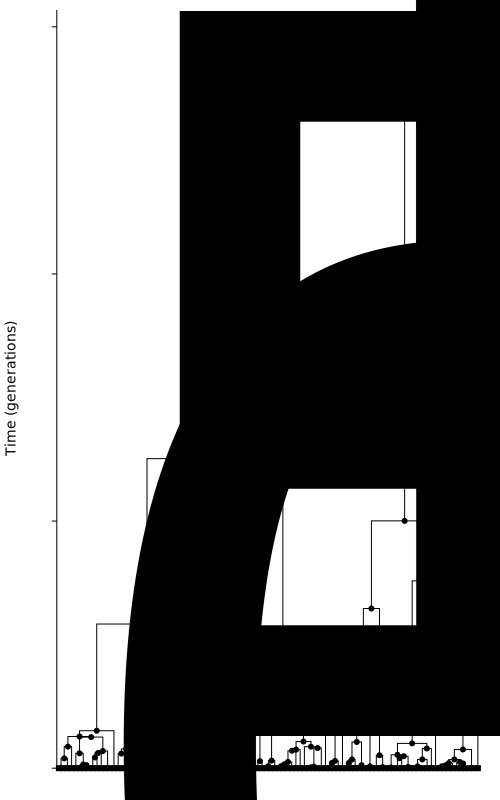

In [350]:
node_label_style = (
    ".node > .lab {font-size: 0}"
    ".mut > .lab {font-size: 0}"
    ".y-axis .ticks .lab {font-size: 200%; text-anchor: start; transform: translate(-15px) rotate(90deg)"
)

T.draw_svg(
    size=(500, 800),
#    time_scale="log_time",
    y_axis=True,
    y_label="Time (generations) ",
    omit_sites=True,
    style=node_label_style,
    y_ticks=np.arange(0,20000,5000),
    max_time=15000,
)

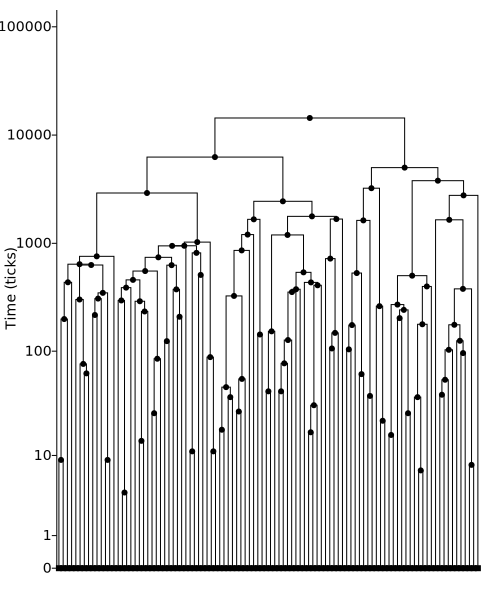

In [351]:
node_label_style = (
    ".node > .lab {font-size: 0}"
    ".mut > .lab {font-size: 0}"
)

T.draw_svg(
    size=(500, 600),
    time_scale="log_time",
    y_axis=True,
    omit_sites=True,
    style=node_label_style,
    y_ticks=[0,1,10,100,1000,10000,100000],
    max_time=100000,
)

In [352]:
newick_filename

'/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/neutral_desai_bigger_20231227/seed=6/output.t=0_n=100.newick'

# Run Bayesian MCP in R

dev.new(): using pdf(file="Rplots14.pdf")


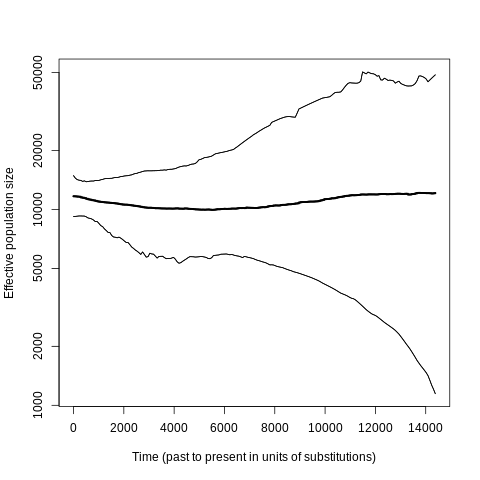

In [353]:
%%R -i newick_filename -o popsize
require("ggplot2")

# Open the conda-installed R in terminal:
# > install.packages("ape", repos='http://cran.us.r-project.org')
require("ape")

tr = read.tree(file=newick_filename)

mcmc.out <- mcmc.popsize(
    tr, 
    10000, 
    thinning=10, 
    burn.in=1000,
)

popsize <- extract.popsize(mcmc.out)

## S3 method for class 'popsize'
plot(popsize, show.median=TRUE, show.years=FALSE, subst.rate, present.year, xlab = NULL, ylab = "Effective population size")

## S3 method for class 'popsize'
lines(popsize, show.median=TRUE,show.years=FALSE, subst.rate, present.year)



In [354]:
popsize_df = pd.DataFrame(popsize, columns=["time", "mean", "median", "lower", "upper"])

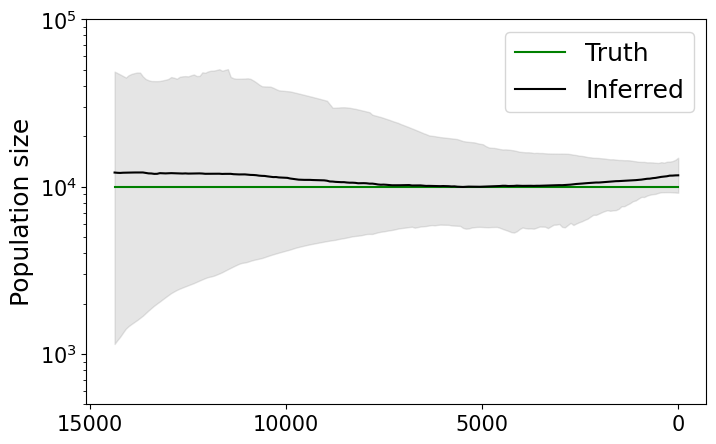

In [355]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(popsize_df["time"], np.ones_like(popsize_df["time"])*10000, color="green", label="Truth")
ax.plot(popsize_df["time"], popsize_df["median"], color="black", label="Inferred")
ax.fill_between(popsize_df["time"], popsize_df["lower"], popsize_df["upper"], color="gray", alpha=0.2)
ax.set_yscale("log")
ax.legend(fontsize=18)
ax.set_ylim(500,100000)
#ax.set_xlabel("Generations ago")
ax.set_ylabel("Population size", fontsize=18)
ax.set_xticks([0,5000,10000,15000])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.invert_xaxis()


# Non-neutral tree plots

In [418]:
filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=*/output.trees")
#filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/neutral_desai_bigger_20231227/seed=*/output.trees")

trees_filename = filenames[6]

In [419]:
n_samples_per_time = 100

ts = loader.load_tree_sequence_from_slim(
    filename = trees_filename,
    n_samples_per_time = [n_samples_per_time],
    sample_times = [0],
    neutral_mutation_rate_per_genome = 1e-2,
    random_seed = 42,
    recapitate = True,
    recapitate_Ne = 10000, 
)

/home/rs2145/rs2145/software/anaconda3/envs/dated_selection/lib/python3.10/site-packages/msprime/ancestry.py:831: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  warnings.warn(message, TimeUnitsMismatchWarning)


In [420]:
newick_filename = trees_filename.replace(".trees", f".t=0_n={n_samples_per_time}.newick")


T = ts.first().split_polytomies(random_seed=42)
assert len(T.roots) == 1, f"# roots = {len(T.roots)}"
with open(newick_filename, "w") as F:
    F.write(T.as_newick())

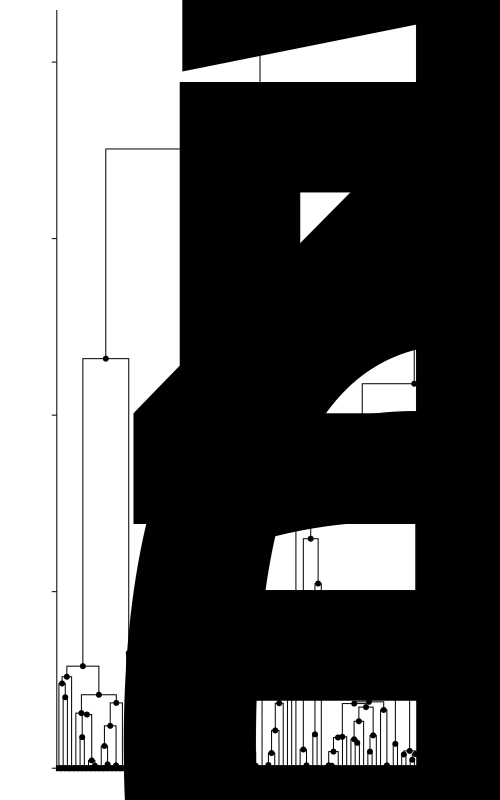

In [431]:
node_label_style = (
    ".node > .lab {font-size: 0}"
    ".mut > .lab {font-size: 0}"
    ".y-axis .ticks .lab {font-size: 200%; text-anchor: start; transform: translate(-15px) rotate(90deg)"
)

T.draw_svg(
    size=(500, 800),
#    time_scale="log_time",
    y_axis=True,
    y_label=" ",
    omit_sites=True,
    style=node_label_style,
    y_ticks=np.arange(0,2500,500),
    max_time=2100,
)

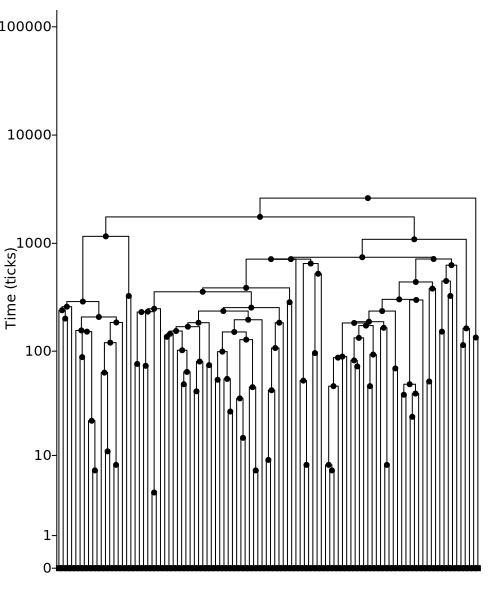

In [422]:
node_label_style = (
    ".node > .lab {font-size: 0}"
    ".mut > .lab {font-size: 0}"
)

T.draw_svg(
    size=(500, 600),
    time_scale="log_time",
    y_axis=True,
    omit_sites=True,
    style=node_label_style,
    y_ticks=[0,1,10,100,1000,10000,100000],
    max_time=100000,
)

In [423]:
newick_filename

'/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=83/output.t=0_n=100.newick'

In [212]:
ape_newick_filename = newick_filename.replace(".newick", ".ape.newick")

In [215]:
%%R -i newick_filename,ape_newick_filename
require("ape")
write.tree(read.tree(file=newick_filename), ape_newick_filename)


# Run Bayesian MCP in R

dev.new(): using pdf(file="Rplots21.pdf")


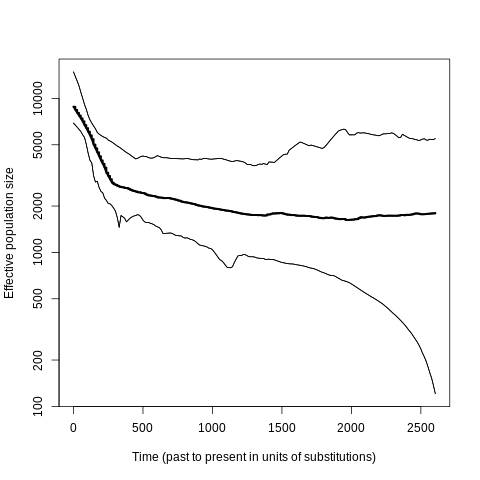

In [424]:
%%R -i newick_filename -o popsize
require("ggplot2")

# Open the conda-installed R in terminal:
# > install.packages("ape", repos='http://cran.us.r-project.org')
require("ape")

tr = read.tree(file=newick_filename)

mcmc.out <- mcmc.popsize(
    tr, 
    10000, 
    thinning=10, 
    burn.in=1000,
)

popsize <- extract.popsize(mcmc.out)

## S3 method for class 'popsize'
plot(popsize, show.median=TRUE, show.years=FALSE, subst.rate, present.year, xlab = NULL, ylab = "Effective population size")

## S3 method for class 'popsize'
lines(popsize, show.median=TRUE,show.years=FALSE, subst.rate, present.year)



In [425]:
popsize_df = pd.DataFrame(popsize, columns=["time", "mean", "median", "lower", "upper"])

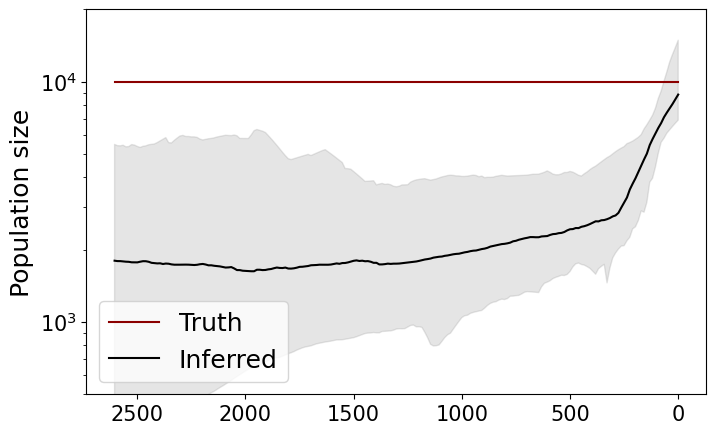

In [436]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(popsize_df["time"], np.ones_like(popsize_df["time"])*10000, color="darkred", label="Truth")
ax.plot(popsize_df["time"], popsize_df["median"], color="black", label="Inferred")
ax.fill_between(popsize_df["time"], popsize_df["lower"], popsize_df["upper"], color="gray", alpha=0.2)
ax.set_yscale("log")
ax.legend(fontsize=18)
ax.set_ylim(500,20000)
#ax.set_xlabel("Generations ago")
ax.set_ylabel("Population size", fontsize=18)
ax.set_xticks([0,500,1000,1500,2000,2500])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.invert_xaxis()


# BactDating

In [7]:
filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=*/output.trees")
#filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/neutral_desai_bigger_20231227/seed=*/output.trees")

trees_filename = filenames[6]

In [8]:
n_samples_per_time = 100

ts = loader.load_tree_sequence_from_slim(
    filename = trees_filename,
    n_samples_per_time = [n_samples_per_time],
    sample_times = [0],
    neutral_mutation_rate_per_genome = 1e-2,
    random_seed = 42,
    recapitate = True,
    recapitate_Ne = 10000, 
)

/home/rs2145/rs2145/software/anaconda3/envs/dated_selection/lib/python3.10/site-packages/msprime/ancestry.py:831: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  warnings.warn(message, TimeUnitsMismatchWarning)


In [9]:
newick_filename = trees_filename.replace(".trees", f".t=0_n={n_samples_per_time}.newick")


T = ts.first().split_polytomies(random_seed=42)
assert len(T.roots) == 1, f"# roots = {len(T.roots)}"
with open(newick_filename, "w") as F:
    F.write(T.as_newick())

In [54]:
from Bio import Phylo
import copy

N = Phylo.read(newick_filename, "newick")

In [116]:
def build_tree(ts, tree, node):
    branch_length = int(np.sum(ts.mutations_node == node))
    
    clades = None
    
    children = tree.children(node)
    if len(children):
        clades = [build_tree(ts, tree, c) for c in children]
    
    clade = Phylo.BaseTree.Clade(branch_length=branch_length, clades=clades, name=str(node))
    return clade
        

In [81]:
modified_newick_filename = newick_filename.replace(".newick", ".in_subs.newick")

In [117]:
modified_N = Phylo.BaseTree.Tree.from_clade(build_tree(ts, T, T.root), rooted='True')

In [118]:
Phylo.write(modified_N, modified_newick_filename, "newick")

1

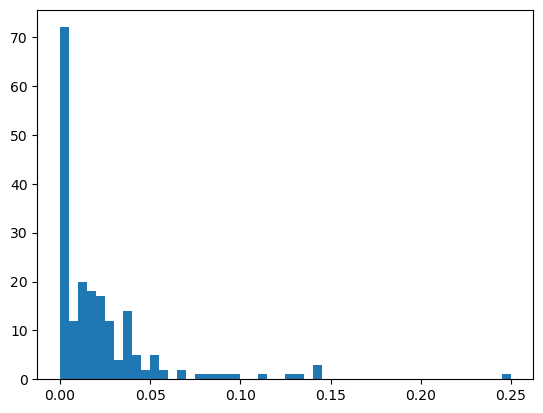

In [243]:
branch_lengths, mut_nums = np.array([((ts.nodes_time[ts.edges_parent[ts.edges_child == n][0]]-ts.nodes_time[n]),  int(np.sum(ts.mutations_node == n))) \
     for n in ts.first().nodes() if len(ts.edges_parent[ts.edges_child == n]) == 1]).T

# sns.regplot(pd.DataFrame({"branch_lengths": branch_lengths, "mut_nums": mut_nums}), x="branch_lengths", y="mut_nums", order=2)
# plt.xlim(0,500);
# plt.ylim(0,5);
plt.hist(mut_nums/branch_lengths, bins=50);

In [119]:
%%R -i modified_newick_filename
require("ggplot2")

# Open the conda-installed R in terminal:
# > install.packages("ape", repos='http://cran.us.r-project.org')
require("ape")

# > devtools::install_github("xavierdidelot/BactDating")
require("BactDating")

tr = read.tree(file=modified_newick_filename)

res = bactdate(tr, rep(2000, length(tr$tip.label)))

res

Phylogenetic tree dated using BactDating

Phylogenetic tree with 100 tips and 99 internal nodes.

Tip labels:
  4, 12, 93, 34, 44, 25, ...
Node labels:
  197, 149, 196, 194, 157, 145, ...

Rooted; includes branch lengths.
Probability of root branch=0.99
likelihood=-2.96e+02 [-3.11e+02;-2.83e+02]
prior=-5.42e+02 [-5.82e+02;-4.78e+02]
mu=1.16e+00 [7.11e-01;2.15e+00]
sigma=1.22e-01 [1.88e-04;5.75e-01]
alpha=9.19e+01 [4.30e+01;1.45e+02]
Root date=1971.05 [1955.60;1985.97]
Root date for most likely root=1971.01 [1955.74;1985.91]


In [120]:
bactdating_newick_filename = modified_newick_filename.replace(".newick", ".bactdating.newick")

In [121]:
%%R -i bactdating_newick_filename
out=extractSample(res,1)

write.tree(out[[1]], bactdating_newick_filename)

# mcmc.out <- mcmc.popsize(
#     out[[3]], 
#     10000, 
#     thinning=10, 
#     burn.in=1000,
# )

# popsize <- extract.popsize(mcmc.out)

# ## S3 method for class 'popsize'
# plot(popsize, show.median=TRUE, show.years=FALSE, subst.rate, present.year, xlab = NULL, ylab = "Effective population size")

# ## S3 method for class 'popsize'
# lines(popsize, show.median=TRUE,show.years=FALSE, subst.rate, present.year)


[1] "phylo"


In [272]:
modified_newick_filename

'/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=83/output.t=0_n=100.in_subs.newick'

In [131]:
bactdating_newick_filename

'/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=83/output.t=0_n=100.in_subs.bactdating.newick'

In [210]:
import newick
nn = newick.loads(open(modified_newick_filename).read().strip())[0]
node_to_n_mutations = dict([(n.name, n.length) for n in nn.walk()])

In [290]:
import newick
bnn = newick.loads(open(bactdating_newick_filename).read().strip())[0]
node_to_branch_length = dict([(n.name, n.length) for n in bnn.walk()])

In [252]:
bdts = tsconvert.from_newick(open(bactdating_newick_filename).read().strip())


In [255]:
bdts.num_nodes

199

/tmp/ipykernel_2866606/3094616504.py:17: RuntimeWarning: invalid value encountered in divide
  plt.plot(B/A)


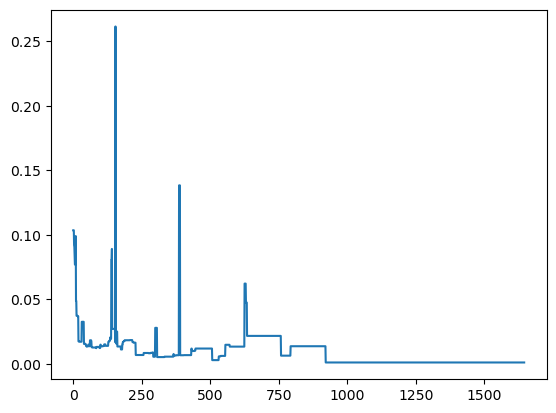

In [303]:
A = np.zeros(int(bdts.nodes_time[bdts.first().root]+1)*100)
B = np.zeros(int(bdts.nodes_time[bdts.first().root]+1)*100)
for edge in bdts.edges():
    A[int(bdts.nodes_time[edge.child]*100):int(bdts.nodes_time[edge.parent]*100)] += 1
    
for sn, n_mut in node_to_n_mutations.items():
    n = int(sn)
    if np.sum(bdts.edges_child == n):
        edge = np.where(bdts.edges_child == n)[0][0]        
        s,e = int(bdts.nodes_time[bdts.edges_child[edge]]*100), int(bdts.nodes_time[bdts.edges_parent[edge]]*100)
        # if s==e:
        #     print(edge, sn,n_mut)
        #     break
        B[s:e] += n_mut/(e-s)

#plt.plot(B)
plt.plot(B/A)
# plt.ylim(0,0.05)

In [281]:
bdts.edge(28)

Edge(left=0.0, right=1.0, parent=146, child=149, metadata=b'', id=28)

In [287]:
bdts.nodes_time[146]

0.19341110812999673

In [293]:
node_to_n_mutations["146"]

0.0

In [302]:
max(bdts.nodes_time)

16.46298355993

In [111]:
import tsconvert

/tmp/ipykernel_2866606/1755195156.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(B/A)


(0.0, 0.05)

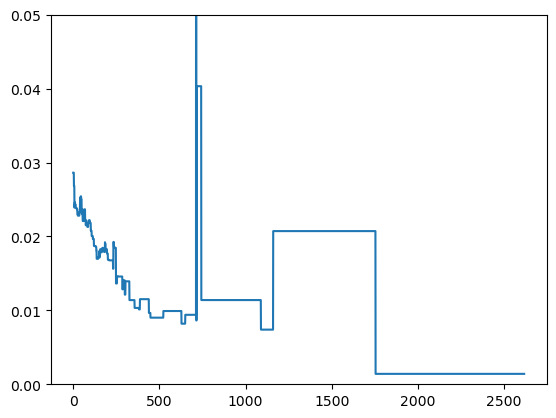

In [297]:
oldts = tsconvert.from_newick(open(newick_filename).read().strip())
A = np.zeros(int(oldts.nodes_time[oldts.first().root]+1))
B = np.zeros(int(oldts.nodes_time[oldts.first().root]+1))
for edge in oldts.edges():
    A[int(oldts.nodes_time[edge.child]):int(oldts.nodes_time[edge.parent])] += 1
for mut in ts.mutations():
    edge = mut.edge
    s,e = int(oldts.nodes_time[oldts.edges_child[edge]]), int(oldts.nodes_time[oldts.edges_parent[edge]])
    B[s:e] += 1.0/(e-s)
    
plt.plot(B/A)
plt.ylim(0,0.05)

In [173]:
bactdating_newick_filename

'/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=83/output.t=0_n=100.in_subs.bactdating.newick'

# Mutation rates

In [387]:
def get_mutation_counts_and_lineages_for_ts(
    filename, 
    max_generations, 
    sample_times, 
    sample_sizes,
    n_bins,
    neutral_mutation_rate_per_genome = 0,
):
#     # Load file
#     ts = tskit.load(filename)
    
#     # Remove the empty second chromosomes and their associates useless mutations
#     sts = ts.simplify(np.arange(0, len(ts.nodes_time), 2))
    
#     # Take subset of samples
#     sts = sts.simplify([sts.individual(i).nodes[0] for sample_time in sample_times for i in pyslim.individuals_alive_at(sts, sample_time)])
    
#     # Add neutrals
#     sts = msprime.sim_mutations(
#         sts,
#         rate=neutral_mutation_rate_per_genome/sts.sequence_length,    # per bp
#         model=msprime.SLiMMutationModel(type=3, next_id=pyslim.next_slim_mutation_id(sts)), # type=3 is just any mutation type unused in the simulation
#         keep=True, 
#         discrete_genome=True,
#         random_seed=random_seed,
#     )
    sts = loader.load_tree_sequence_from_slim(filename, sample_sizes, sample_times, neutral_mutation_rate_per_genome) 
    
    mutation_times = []
    mutation_weights = []
    for variant in sts.variants():
        for mutation in variant.site.mutations:
            mutation_times.append(mutation.time)
            mutation_weights.append(sts.num_samples - variant.counts()[''])
    
    hist_bins = np.linspace(0, max_generations, n_bins+1, endpoint=True)
    mut_counts_per_bin = np.histogram(mutation_times, bins=hist_bins, weights=mutation_weights)[0]

    n_lineages = np.zeros(max_generations, dtype=int)
    for sample_time, sample_size in zip(sample_times, sample_sizes):
        n_lineages[sample_time:] += sample_size
    n_lineages_per_bin = n_lineages.reshape((n_bins, -1)).sum(axis=1)
    
    return mut_counts_per_bin, n_lineages_per_bin
    

In [412]:
filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=*/output.trees")
#filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/neutral_desai_20230626/seed=*/output.trees")
    
n_bins = 4000
max_generations = 4000
hist_bins = np.linspace(0, max_generations, n_bins+1, endpoint=True)
all_res = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(get_mutation_counts_and_lineages_for_ts)(filename, max_generations, [0], [1000], n_bins, 0) \
           for filename in filenames
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of 100 | elapsed:    0.4s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  15 out of 100 | elapsed:    0.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  26 out of 100 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  48 out of 100 | elapsed:    0.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  59 out of 100 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of 100 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  81 out of 100 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


In [413]:
mut_counts_per_bin, n_lineages_per_bin = np.array(all_res).sum(axis=0)

mutation_rate_est = mut_counts_per_bin / n_lineages_per_bin
mutation_rate_low_ci, mutation_rate_high_ci = \
    statsmodels.stats.proportion.proportion_confint(mut_counts_per_bin, n_lineages_per_bin, method="beta")

In [414]:
def effective_mutation_rate_theory(t, Ud, s):
    return Ud * np.exp(-s * t)

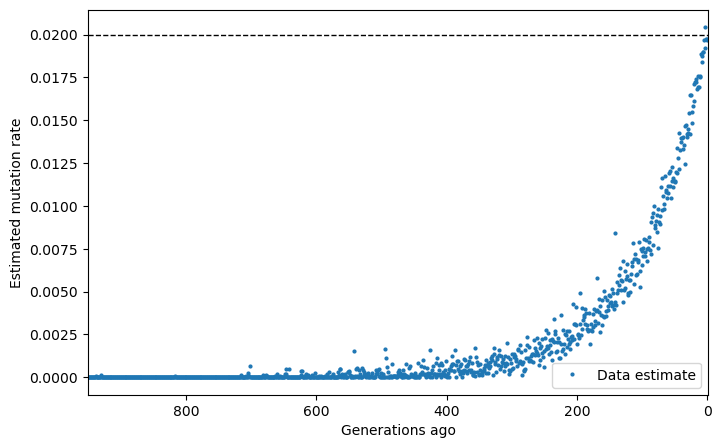

In [415]:
times = hist_bins[:-1]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times, mutation_rate_est, '.', ms=4, label="Data estimate");
#plt.fill_between(times, mutation_rate_low_ci, mutation_rate_high_ci, alpha=0.3, label='Confidence Band')
ax.axhline(0.02, ls='--', lw=1, color="black")
#ax.plot(times, effective_mutation_rate_theory(times, 0.02, 0.01), color="red", label="Expected")
ax.set_xlim(-1,1000-50)
#ax.set_ylim(-0.001, 0.03)
ax.set_xlabel("Generations ago")
ax.set_ylabel(r"Estimated mutation rate")
ax.legend()
ax.invert_xaxis()


[]

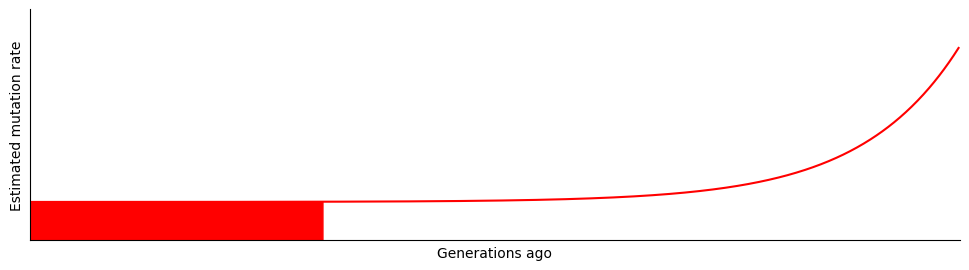

In [376]:
times = hist_bins[:-1]
eu = effective_mutation_rate_theory(times, 0.02, 0.01) + 0.005
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(times, eu, color="red", label="Expected")
ax.fill_between(times[650:], 0, eu[650:], color="red")
ax.set_xlim(-1,1000-50)
ax.set_ylim(0, 0.03)
ax.set_xlabel("Generations ago")
ax.set_ylabel(r"Estimated mutation rate")
#ax.legend()
ax.invert_xaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])


In [352]:
len(times)

4000

# Comparison of two estimators

In [439]:
simple_res_df = pd.read_csv("/home/rs2145/temp/simple_est_noneut_certainty.csv")

In [440]:
simple_res_df

,sample_size,repeat,est_Un,est_Ud,est_s
0,100,0,1.000000e-10,0.016735,0.008851
1,100,1,1.000000e-10,0.023558,0.011662
2,100,2,1.000000e-10,0.022141,0.010347
3,100,3,1.000000e-10,0.018860,0.010194
4,100,4,1.000000e-10,0.021813,0.009360
...,...,...,...,...,...
295,10000,95,1.000000e-10,0.020156,0.009147
296,10000,96,1.000000e-10,0.019033,0.009201
297,10000,97,1.000000e-10,0.022801,0.010944
298,10000,98,1.000000e-10,0.022107,0.012374


In [441]:
cali_df = pd.concat([
    pd.read_csv("/home/rs2145/temp/slim_100.csv", sep="[\s+,]+", engine="python").rename(columns={"Seed": "repeat", "Ud": "est_Ud", "s": "est_s"}).assign(sample_size=100, est_Un=pd.NA),
    pd.read_csv("/home/rs2145/temp/slim_1000.csv", sep="[\s+,]+", engine="python").rename(columns={"Seed": "repeat", "Ud": "est_Ud", "s": "est_s"}).assign(sample_size=1000, est_Un=pd.NA),
    pd.read_csv("/home/rs2145/temp/slim_10000.csv", sep="[\s+,]+", engine="python").rename(columns={"Seed": "repeat", "Ud": "est_Ud", "s": "est_s"}).assign(sample_size=10000, est_Un=pd.NA),
])

In [442]:
res_df = pd.concat([
    simple_res_df.assign(method="Composite"),
    cali_df.assign(method="Full"),
])

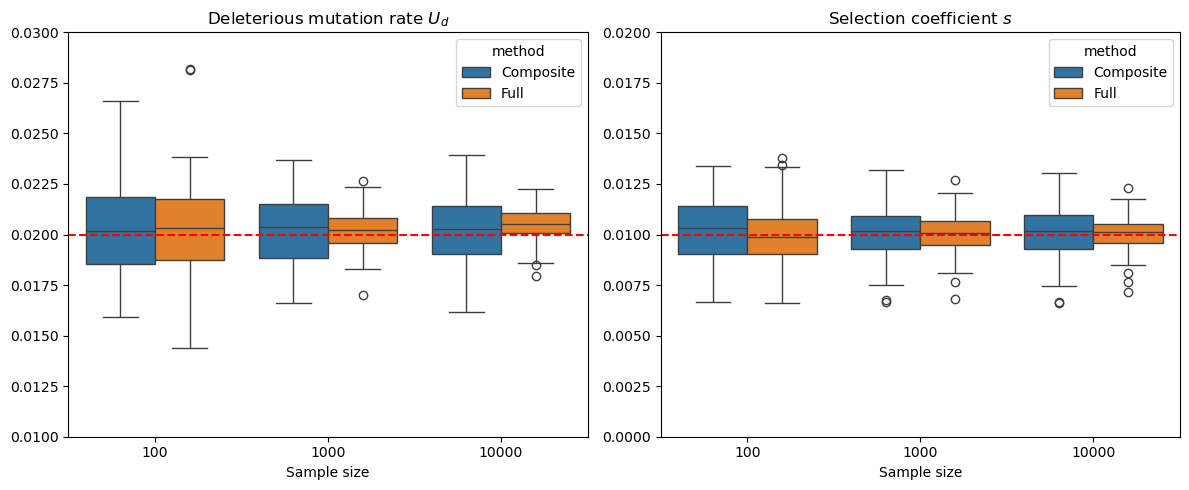

In [445]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(res_df, x="sample_size", y="est_Ud", hue="method", ax=axs[0]);
axs[0].axhline(0.02, color="red", ls="--");
axs[0].set_ylim(0.01, 0.03);
axs[0].set_xlabel("Sample size");
axs[0].set_ylabel("");
axs[0].set_title("Deleterious mutation rate $U_d$");

sns.boxplot(res_df, x="sample_size", y="est_s", hue="method", ax=axs[1]);
axs[1].axhline(0.01, color="red", ls="--");
axs[1].set_ylim(0, 0.02);
axs[1].set_xlabel("Sample size");
axs[1].set_ylabel("");
axs[1].set_title("Selection coefficient $s$");

plt.tight_layout()